## HW1 Sentiment Analysis on Movie Reviews with Dimensionality Reduction

In [1]:
# install package
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
train=pd.read_csv('BBC News Train.csv')

In [3]:
cate_map={'tech':1,'business':2,'sport':3,'entertainment':4,'politics':5}

In [4]:
train["category"]=train["Category"].map(cate_map)

In [5]:
train

,ArticleId,Text,Category,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business,2
1,154,german business confidence slides german busin...,business,2
2,1101,bbc poll indicates economic gloom citizens in ...,business,2
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,2
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,2
1488,1587,apple ipod family expands market apple has exp...,tech,1


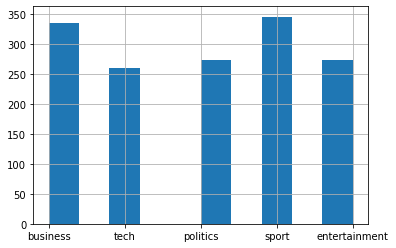

In [6]:
# 檢查label是否分配平均
train["Category"].hist()

In [7]:
train_x = train["Text"].values

In [8]:
label = train["category"].values

In [9]:
train_y = label_binarize(label, classes=[1,2,3,4,5]) 
n_classes = train_y.shape[1]
n_classes

5

In [10]:
train_y

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## Without Dimensionality Reduction
### (i) Bernoulli Naïve Bayes method
### (ii) Random Forest method

### Bernoulli Naïve Bayes method with multi-hot vectors

In [11]:
#convert documents into multi-hot vectors
binary_vectorizer = CountVectorizer(binary=True)
binary_vector=binary_vectorizer.fit_transform(train_x)
vector1=binary_vector.toarray()

In [12]:
vector1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [13]:
vector1.shape

(1490, 24746)

In [14]:
# split 10% of training set for evaluation
split_length=int(len(train_x)*0.9)

In [15]:
split_length

1341

In [16]:
def model_predict(vector,model):
    x_train=vector[:split_length]
    y_train=train_y[:split_length]
    x_evaluation=vector[split_length:]
    y_evaluation=train_y[split_length:]
    model.fit(x_train,y_train)
    predicted_results=[]
    expected_results=[]
    expected_results.extend(y_evaluation)
    predicted_results.extend(model.predict(x_evaluation))
    
    # Show precision, recall, and F1 scores
    # micro avg  F1 scores 
    print(metrics.classification_report(expected_results,predicted_results))
    

In [17]:
def plot_precision_recall_curves(vector,model):

    x_train=vector[:split_length]
    y_train=train_y[:split_length]
    x_evaluation=vector[split_length:]
    y_evaluation=train_y[split_length:]
    #plot precision recall curves
    y_score = model.fit(x_train, y_train).predict_proba(x_evaluation)
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_evaluation[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(y_evaluation[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_evaluation.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_evaluation, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='class {0} (area = {1:0.2f})'.format
        (i+1, average_precision[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multi-Class') 
    plt.legend(loc="best")
    plt.show()

In [18]:
model_predict(vector1,model=OneVsRestClassifier(BernoulliNB()))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       0.94      0.91      0.92        33
           2       0.96      0.96      0.96        28
           3       1.00      0.81      0.90        32
           4       0.93      0.83      0.88        30

   micro avg       0.95      0.90      0.92       149
   macro avg       0.95      0.90      0.92       149
weighted avg       0.95      0.90      0.92       149
 samples avg       0.88      0.90      0.88       149



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.98


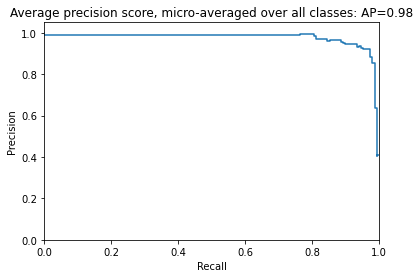

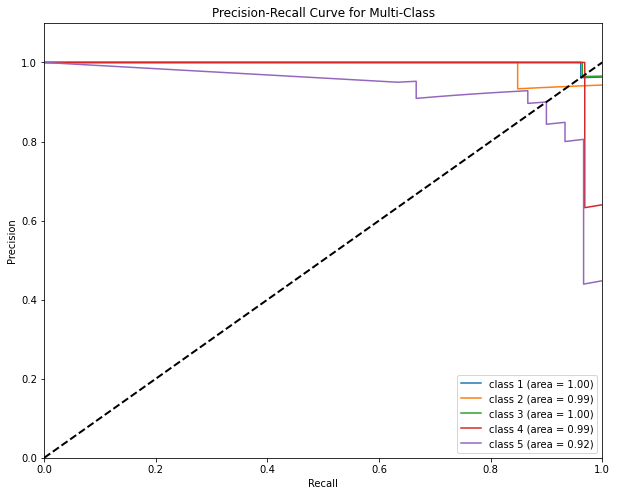

In [19]:
plot_precision_recall_curves(vector1,model=OneVsRestClassifier(BernoulliNB()))

### Random Forest method with Tfidf vectors

In [20]:
Tfidf_vectorizer = TfidfVectorizer(lowercase=True)
Tfidf_vector = Tfidf_vectorizer.fit_transform(train_x)
vector2 = Tfidf_vector.toarray()

In [21]:
vector2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02027404, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02392347, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
vector2.shape

(1490, 24746)

In [23]:
model_predict(vector2,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      0.70      0.82        33
           2       1.00      0.93      0.96        28
           3       1.00      0.75      0.86        32
           4       1.00      0.80      0.89        30

   micro avg       1.00      0.82      0.90       149
   macro avg       1.00      0.83      0.90       149
weighted avg       1.00      0.82      0.90       149
 samples avg       0.82      0.82      0.82       149



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.99


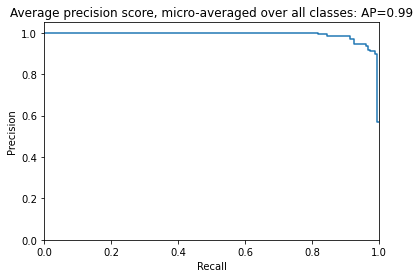

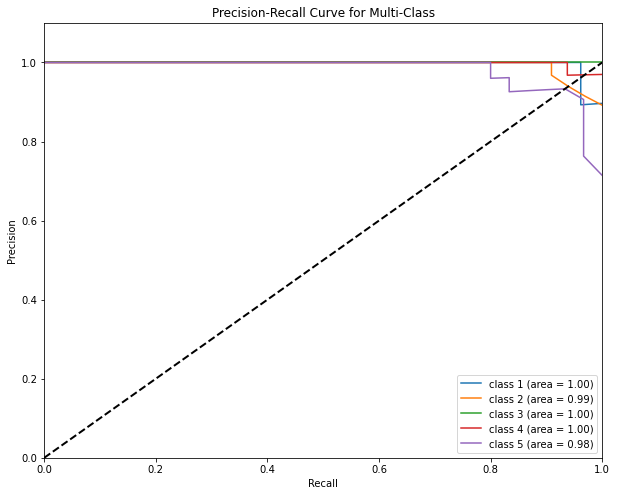

In [24]:
plot_precision_recall_curves(vector2,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

## With Dimensionality Reduction
### methods: 1. PCA  2.SVD  3.t-SNE  using Random Forest method

### PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=8)
vector2_pca = pca.fit_transform(vector2)

In [27]:
vector2_pca

array([[-0.07798296, -0.0180207 , -0.07212412, ...,  0.00711337,
        -0.01214843, -0.05965359],
       [-0.00027471, -0.12625174, -0.054997  , ..., -0.032258  ,
         0.0523183 , -0.01115015],
       [ 0.07096536, -0.08760718, -0.01566581, ...,  0.02540373,
        -0.01297785,  0.03024348],
       ...,
       [-0.04407002, -0.11604269, -0.04761678, ..., -0.02567487,
         0.03945087, -0.03927144],
       [ 0.07343739, -0.20102037,  0.14848855, ..., -0.020062  ,
         0.15223689, -0.0586854 ],
       [-0.03073478, -0.08200967,  0.05863632, ...,  0.01895718,
        -0.10812822,  0.15935211]])

In [28]:
vector2_pca.shape

(1490, 8)

In [29]:
model_predict(vector2_pca,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.96      0.82      0.89        33
           2       0.93      0.89      0.91        28
           3       0.96      0.78      0.86        32
           4       1.00      0.83      0.91        30

   micro avg       0.94      0.85      0.89       149
   macro avg       0.94      0.86      0.89       149
weighted avg       0.95      0.85      0.89       149
 samples avg       0.85      0.85      0.85       149



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.97


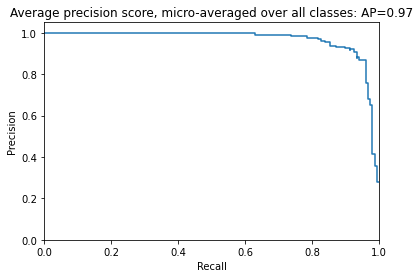

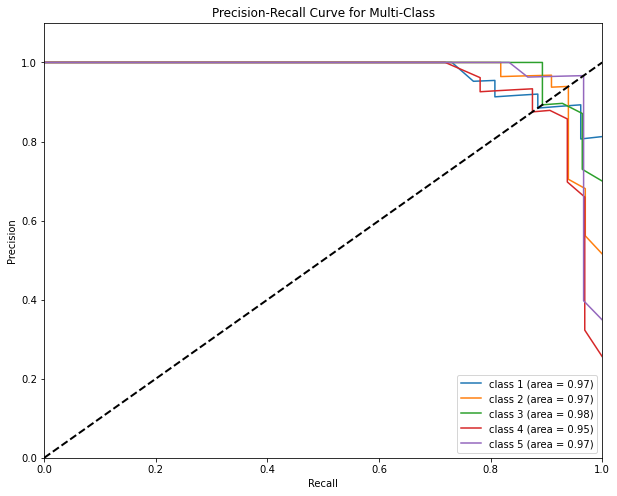

In [30]:
plot_precision_recall_curves(vector2_pca,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

### SVD

In [31]:
from sklearn.decomposition import TruncatedSVD

In [32]:
svd = TruncatedSVD(n_components=8 , random_state=123)

In [33]:
vector2_svd = svd.fit_transform(vector2)

In [34]:
vector2_svd

array([[ 0.21705829,  0.04963335, -0.00747145, ...,  0.08758082,
        -0.10871337, -0.15891153],
       [ 0.35138049, -0.00286416, -0.12689823, ..., -0.05992404,
         0.06264286, -0.0332611 ],
       [ 0.43405367,  0.00195296, -0.09014131, ..., -0.0049321 ,
         0.03323604,  0.06354818],
       ...,
       [ 0.354803  , -0.04029165, -0.12000715, ..., -0.02372852,
         0.0128616 , -0.08219653],
       [ 0.47948676, -0.04393342, -0.21192696, ..., -0.0557871 ,
         0.1415212 , -0.07883494],
       [ 0.29749496, -0.0071301 , -0.08317206, ...,  0.04414038,
        -0.10132153,  0.05540251]])

In [35]:
vector2_svd.shape

(1490, 8)

In [36]:
model_predict(vector2_svd,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.94      0.91      0.92        33
           2       1.00      0.96      0.98        28
           3       1.00      0.88      0.93        32
           4       0.96      0.87      0.91        30

   micro avg       0.96      0.91      0.93       149
   macro avg       0.96      0.91      0.93       149
weighted avg       0.96      0.91      0.93       149
 samples avg       0.91      0.91      0.91       149



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.98


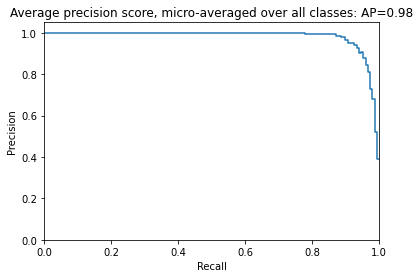

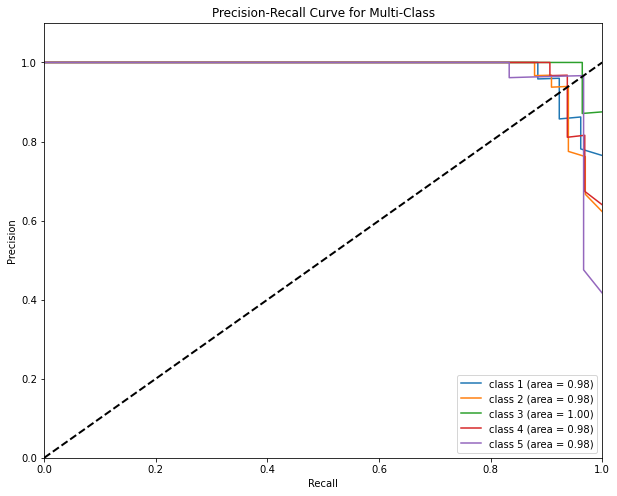

In [37]:
plot_precision_recall_curves(vector2_svd,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

### t-SNE

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(n_components=3,metric="euclidean",random_state=123)

In [40]:
vector2_tsne = tsne.fit_transform(vector2)

In [41]:
vector2_tsne 

array([[  2.981676 ,  11.464464 , -71.46426  ],
       [ 74.927864 ,  -5.1529064,  -7.6685405],
       [ 54.55187  ,  20.53994  , -14.963616 ],
       ...,
       [ 36.992123 , -22.747084 , -34.42803  ],
       [  3.5842497, -28.935223 , -25.85681  ],
       [  3.686727 , -69.60807  , -39.090927 ]], dtype=float32)

In [42]:
vector2_tsne.shape

(1490, 3)

In [43]:
model_predict(vector2_tsne,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.89      0.76      0.82        33
           2       0.97      1.00      0.98        28
           3       0.88      0.72      0.79        32
           4       0.95      0.67      0.78        30

   micro avg       0.91      0.80      0.85       149
   macro avg       0.91      0.81      0.85       149
weighted avg       0.91      0.80      0.85       149
 samples avg       0.79      0.80      0.79       149



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.93


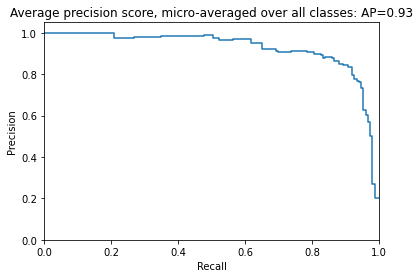

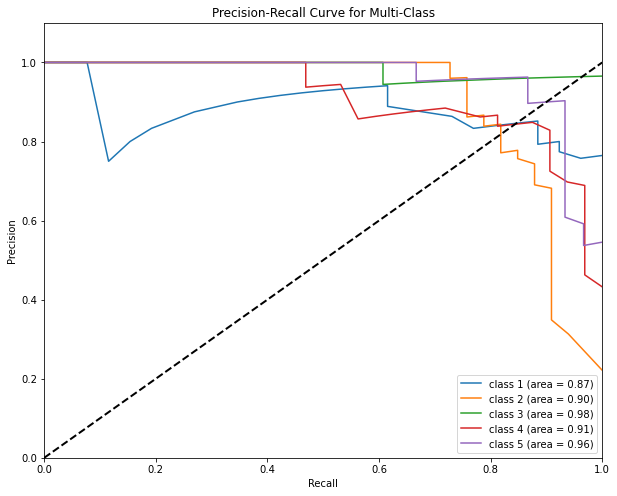

In [44]:
plot_precision_recall_curves(vector2_tsne,model=OneVsRestClassifier(RandomForestClassifier(random_state=123)))

### 降維後視覺化

In [45]:
def plot_outcome(reduction,vector2=vector2,topic="reduction"):
    vector2_tsne = reduction.fit_transform(vector2)
    df=pd.DataFrame(vector2_tsne)
    df['label']=label
    df['text']=train_x
    df['category']=train["Category"]
    plt.figure(figsize=(12,10))
    ax = sns.scatterplot(x=0,y=1,hue='category',s=18,edgecolor="none",data=df)
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.title(str(topic))
    #texts = [plt.text(x[i], y[i], text[i],fontsize=5) for i in range(len(x))]  
    ax.legend(loc='upper right')
    plt.rcParams['savefig.dpi'] = 300 
    plt.rcParams['figure.dpi'] = 300 
    #plt.savefig('hw4.png',dpi=900)  #存檔
    plt.show()

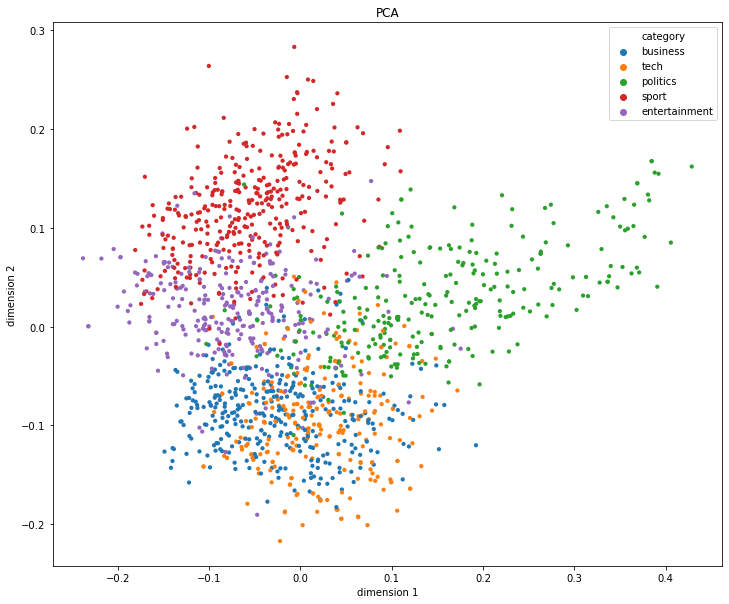

In [46]:
plot_outcome(PCA(n_components=2),topic='PCA')

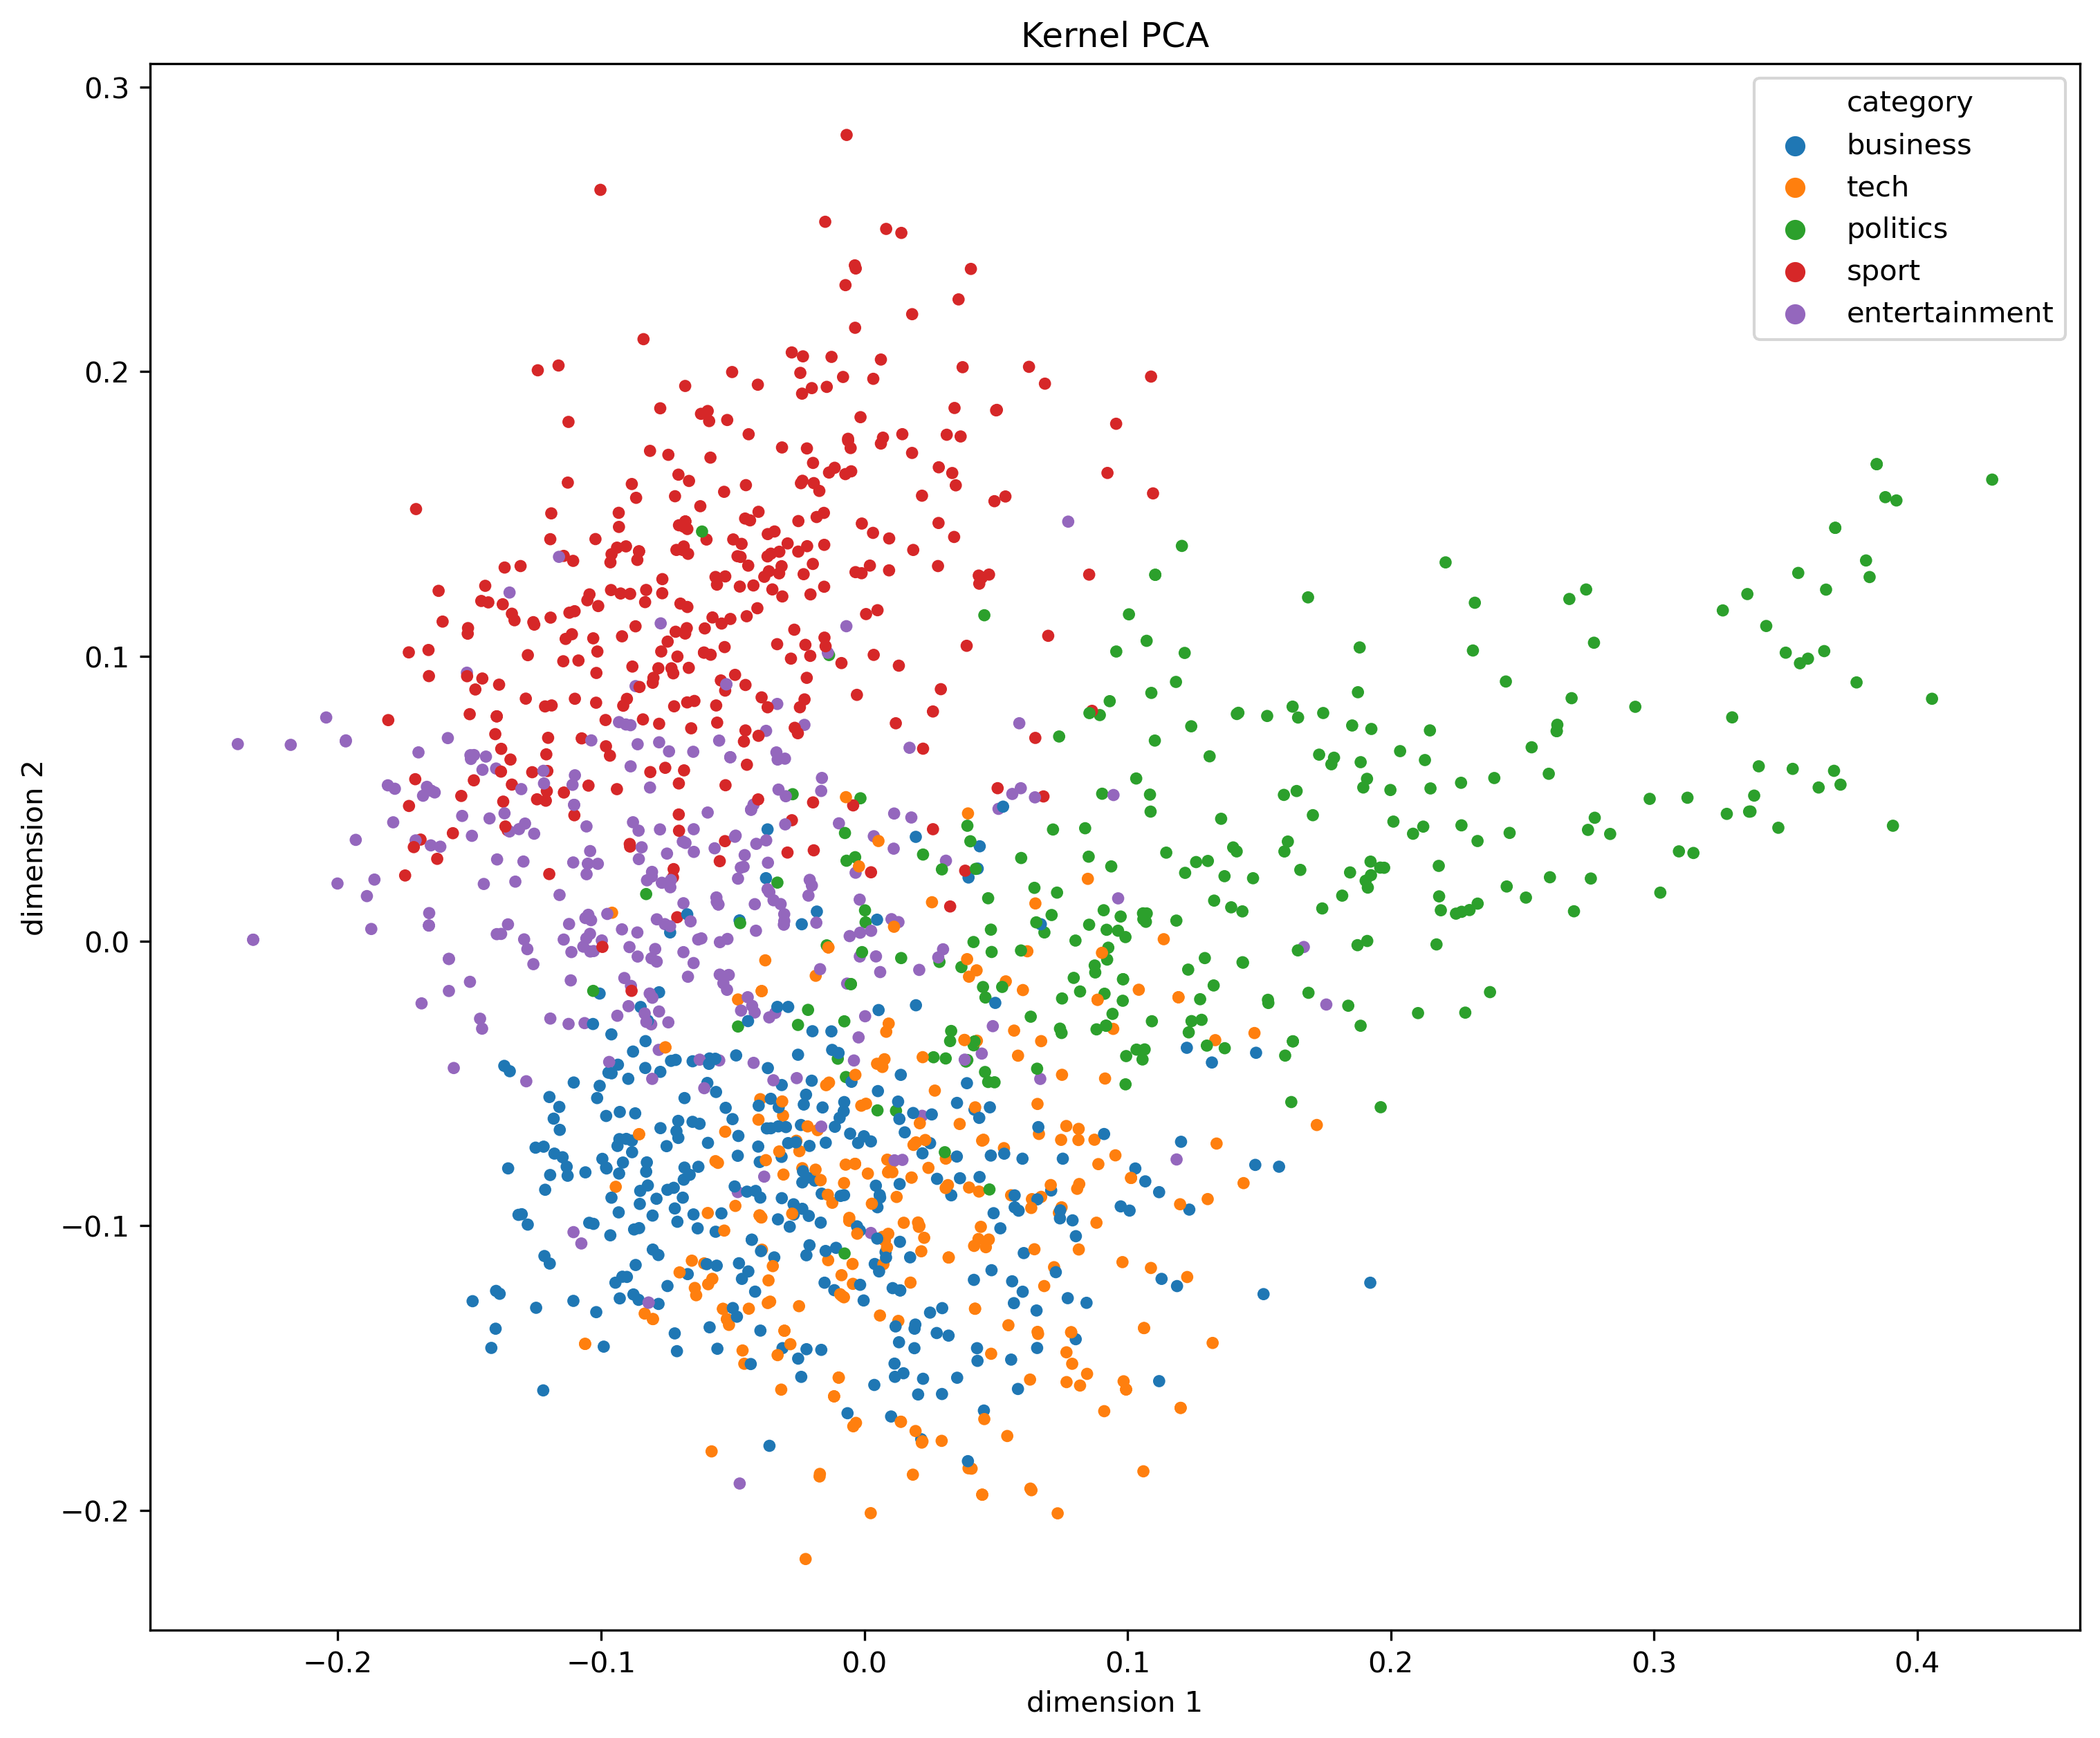

In [47]:
plot_outcome(KernelPCA(n_components=2, kernel="cosine"),topic='Kernel PCA')

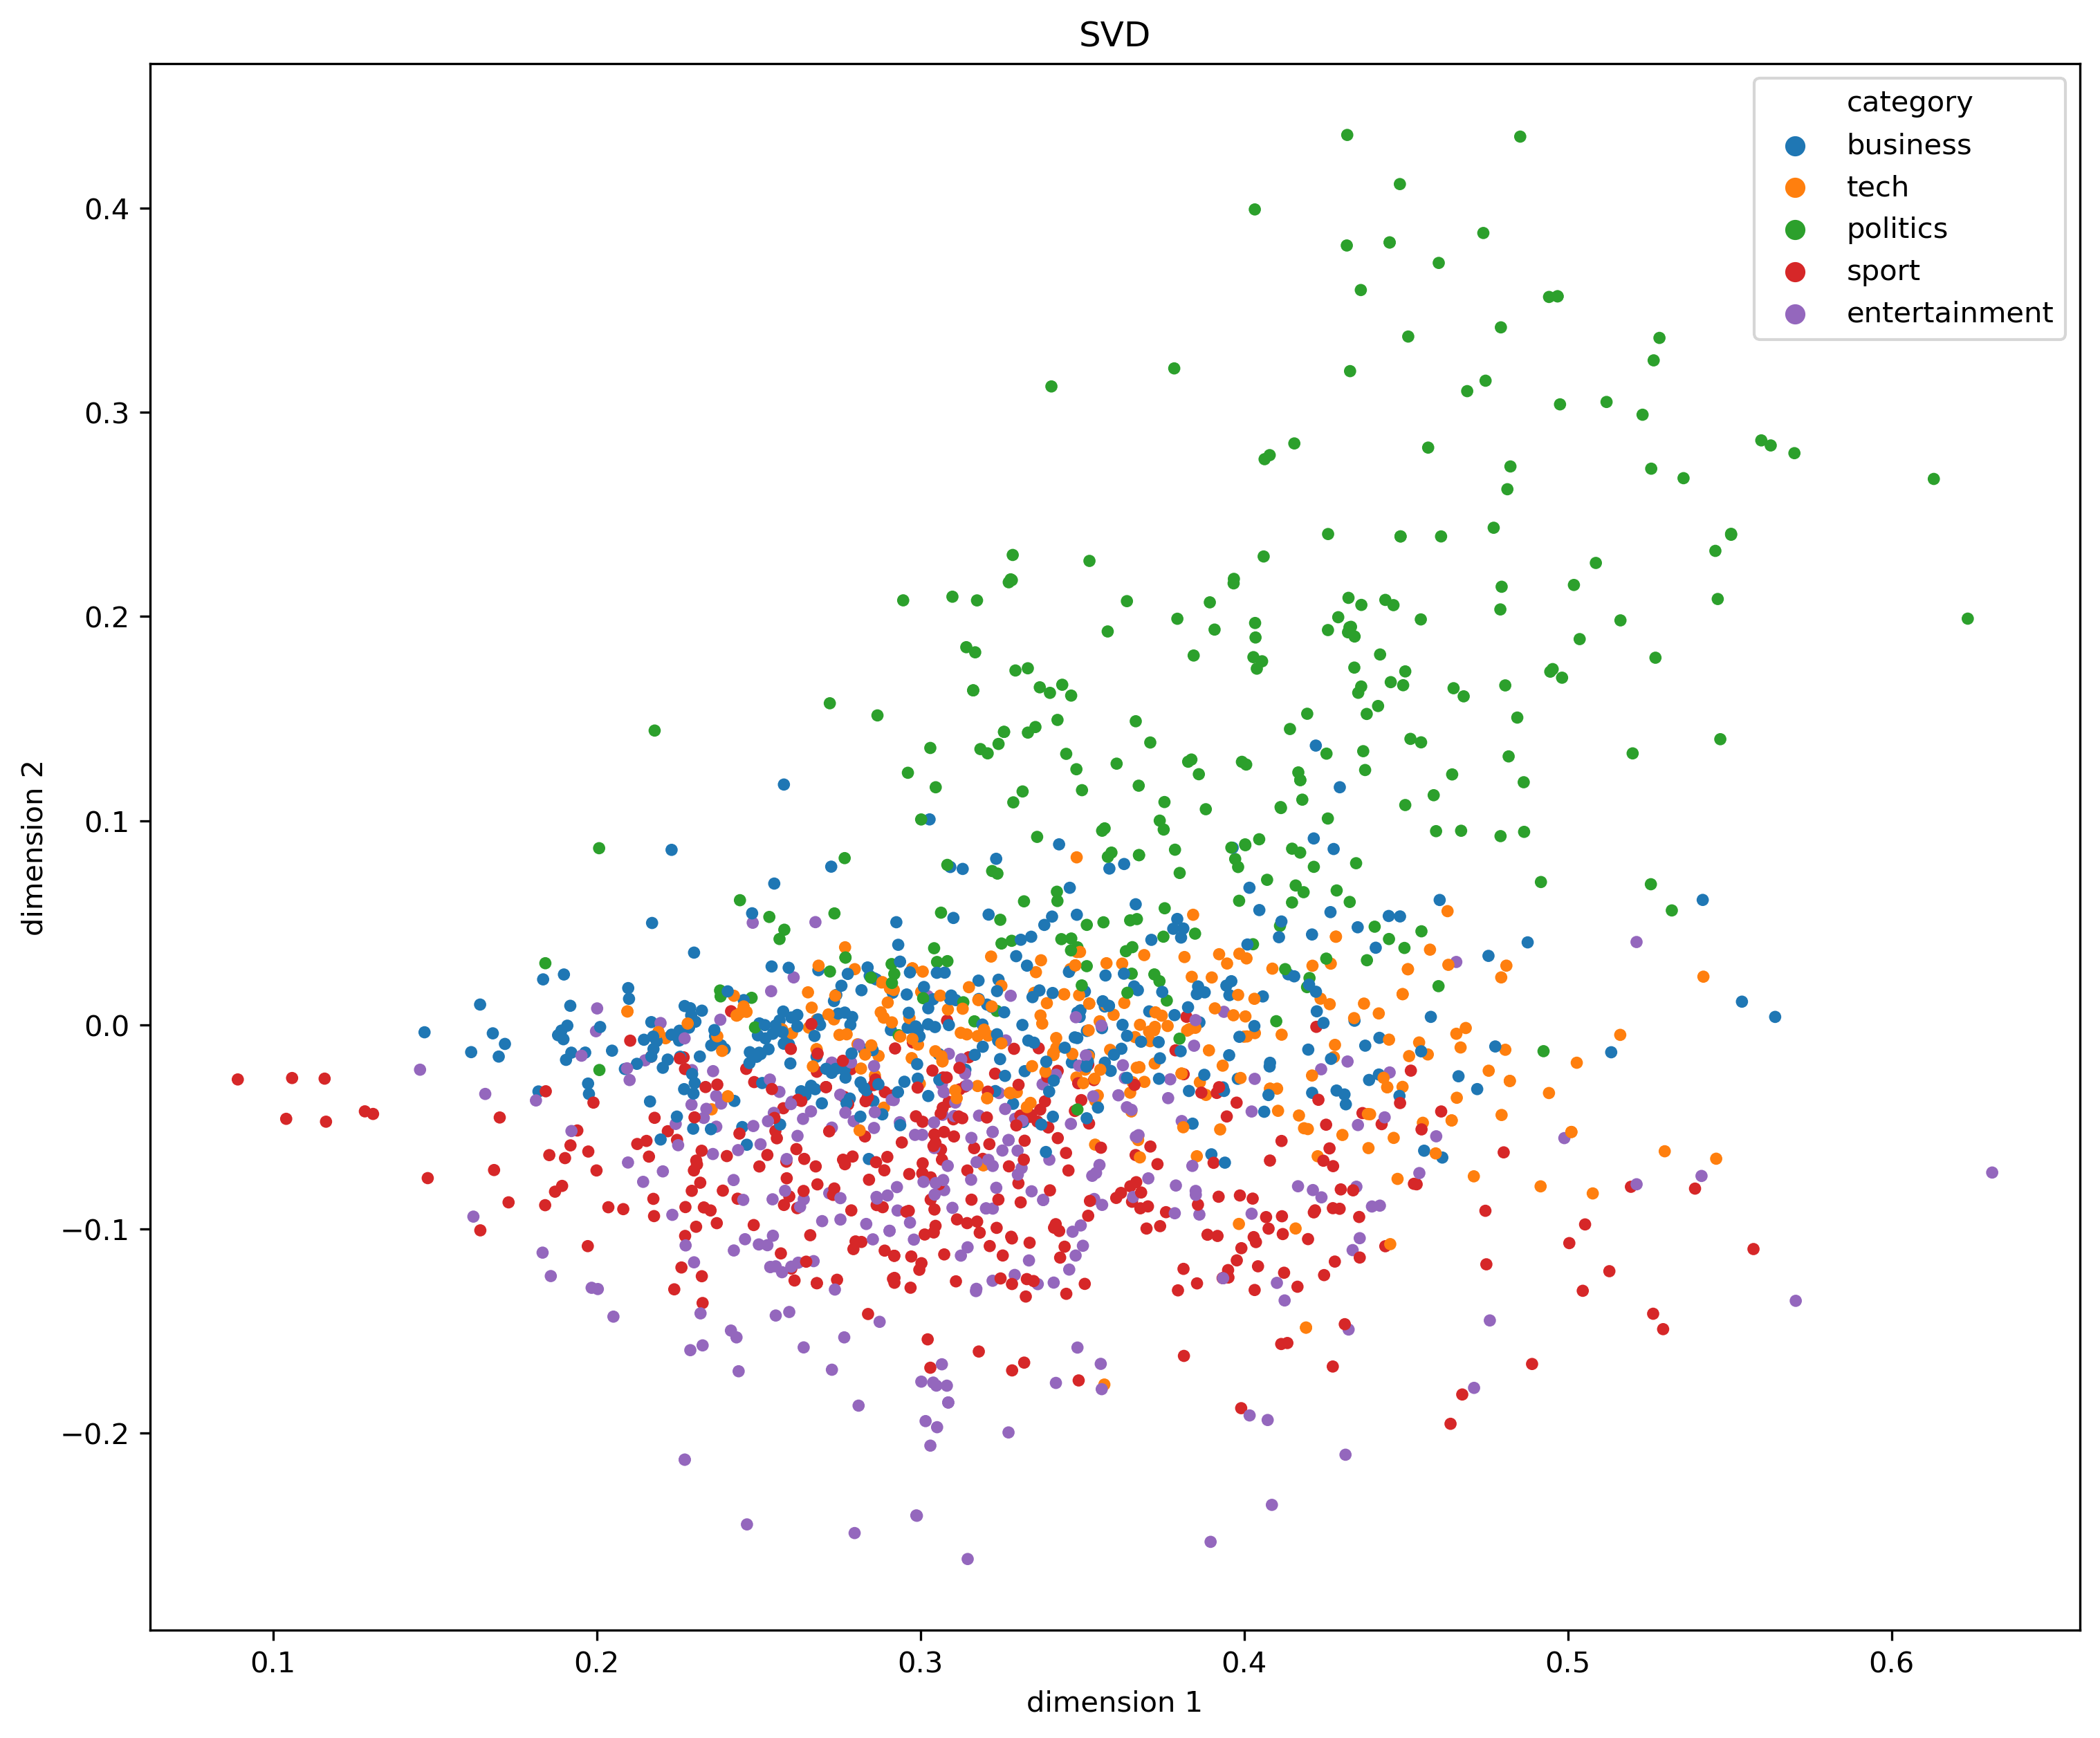

In [48]:
plot_outcome(TruncatedSVD(n_components=2 , random_state=123),topic='SVD')

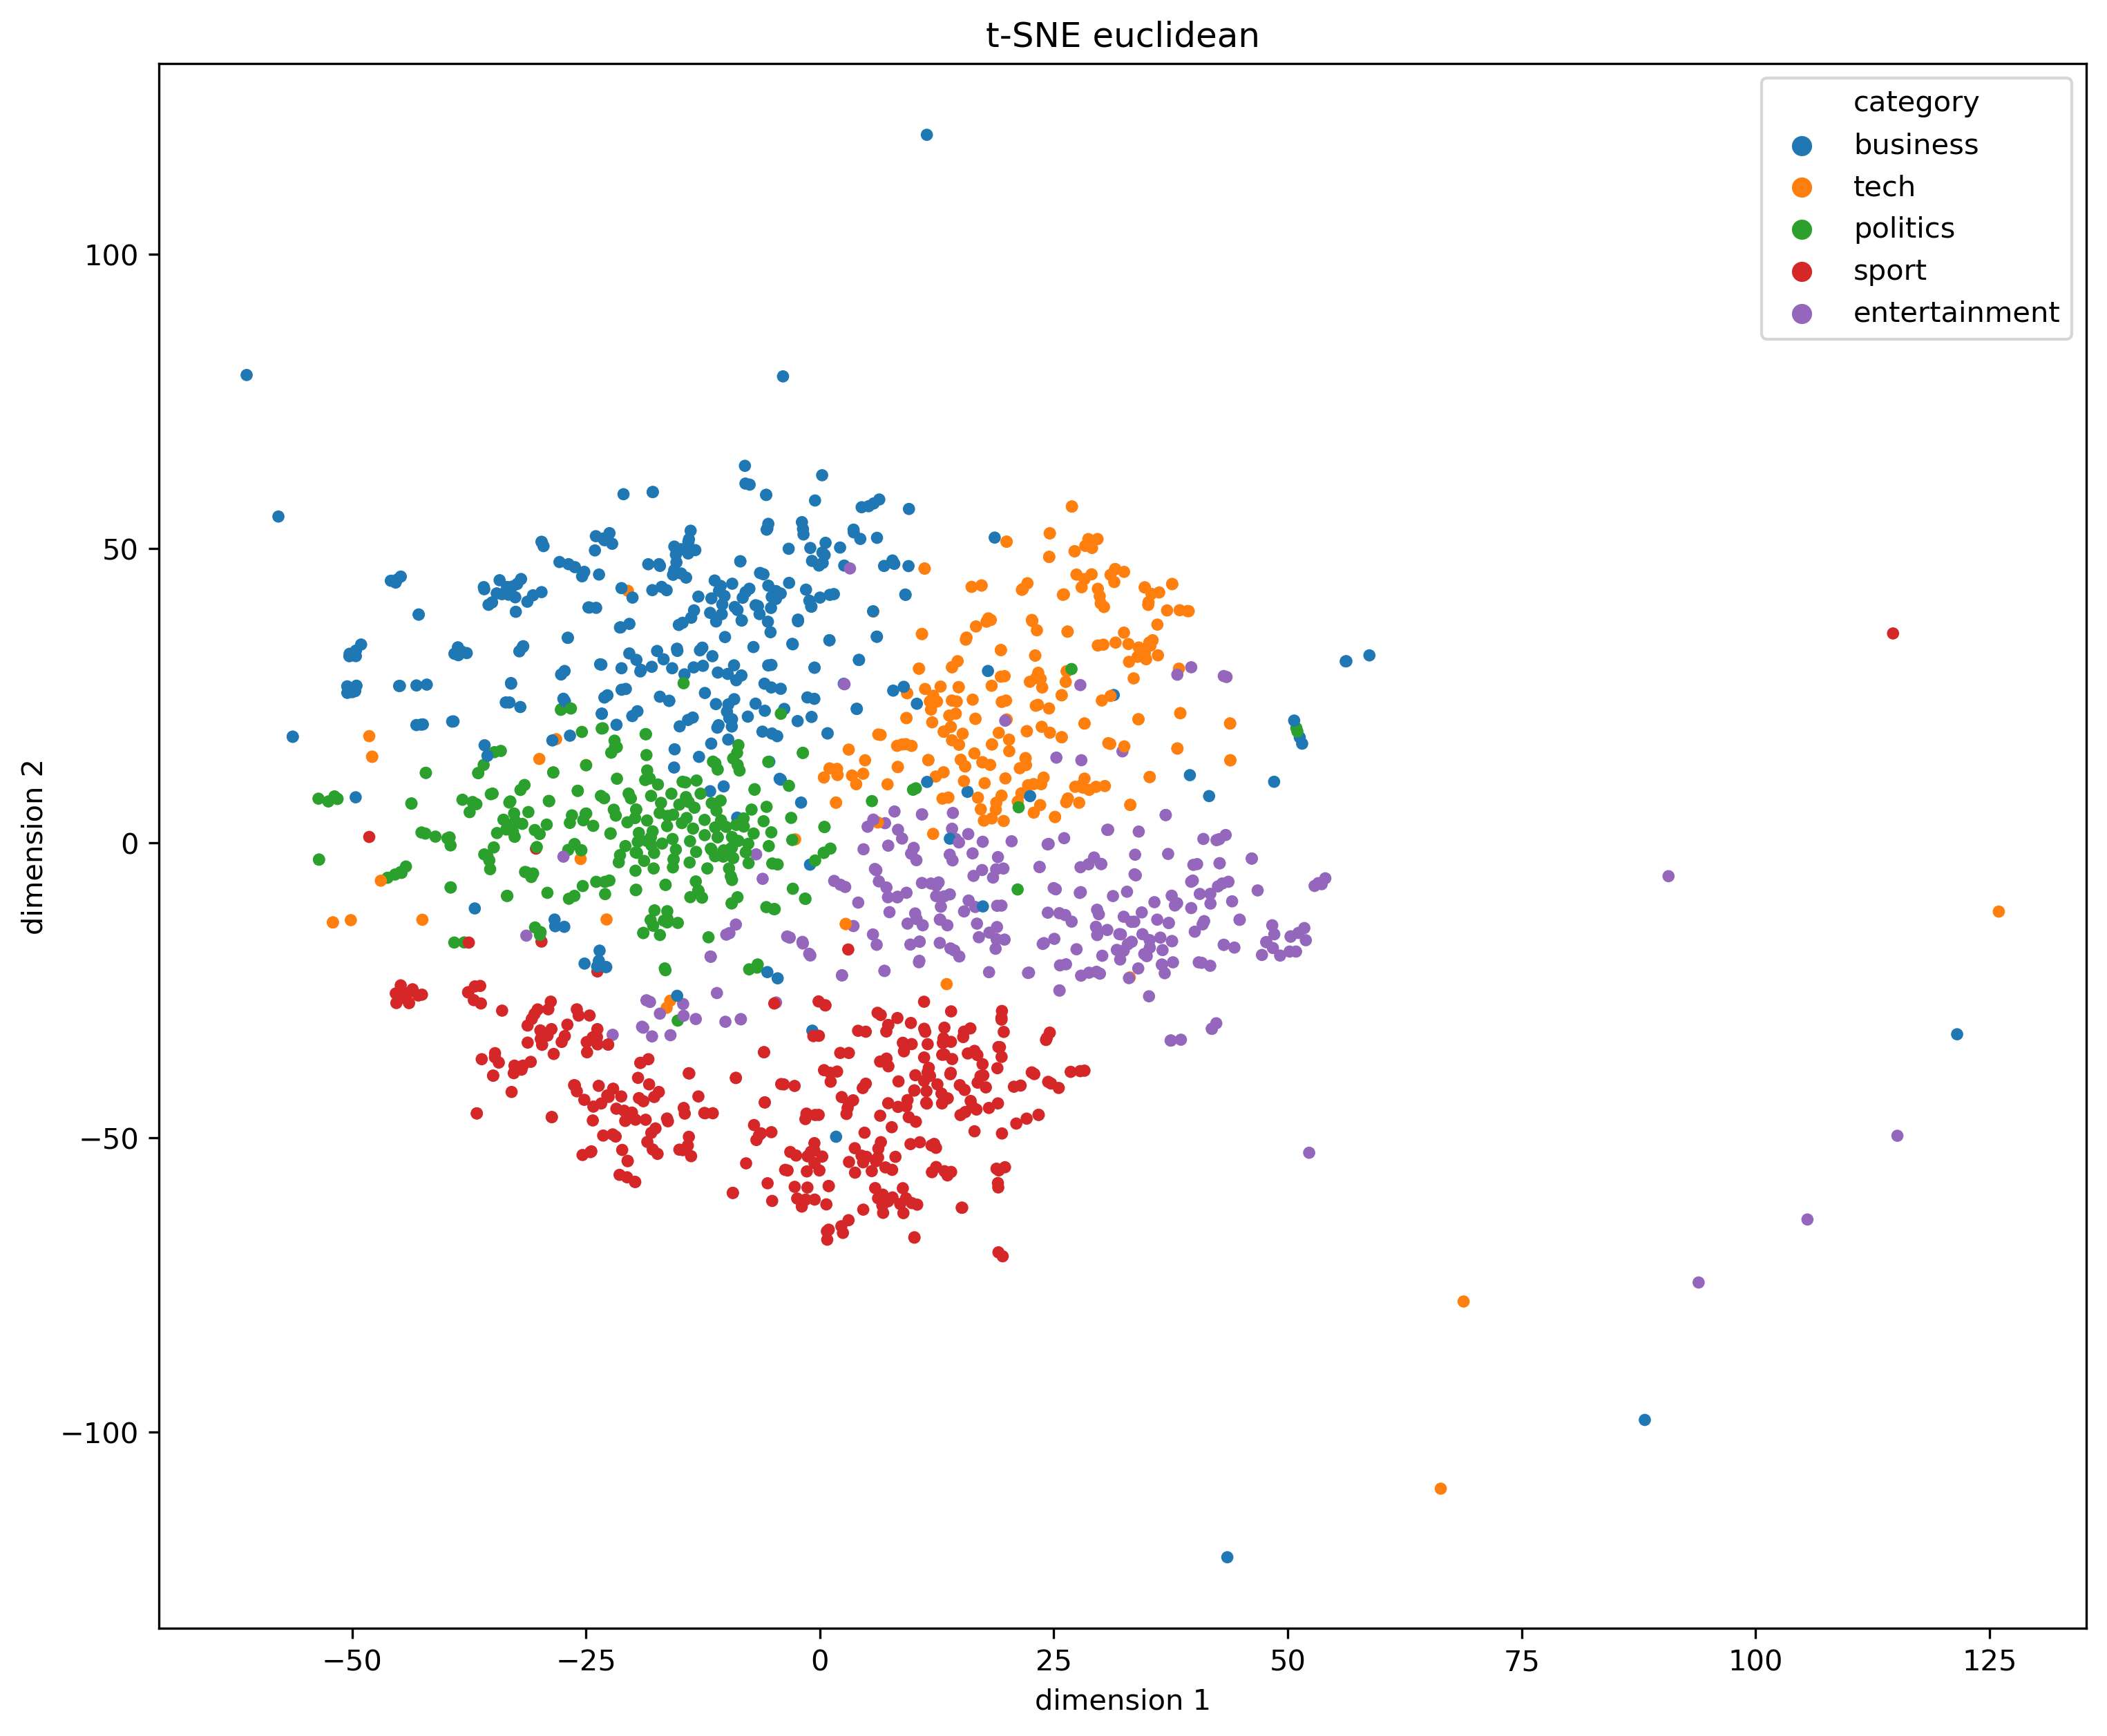

In [49]:
plot_outcome(TSNE(n_components=2,metric="euclidean",random_state=123),topic='t-SNE euclidean')

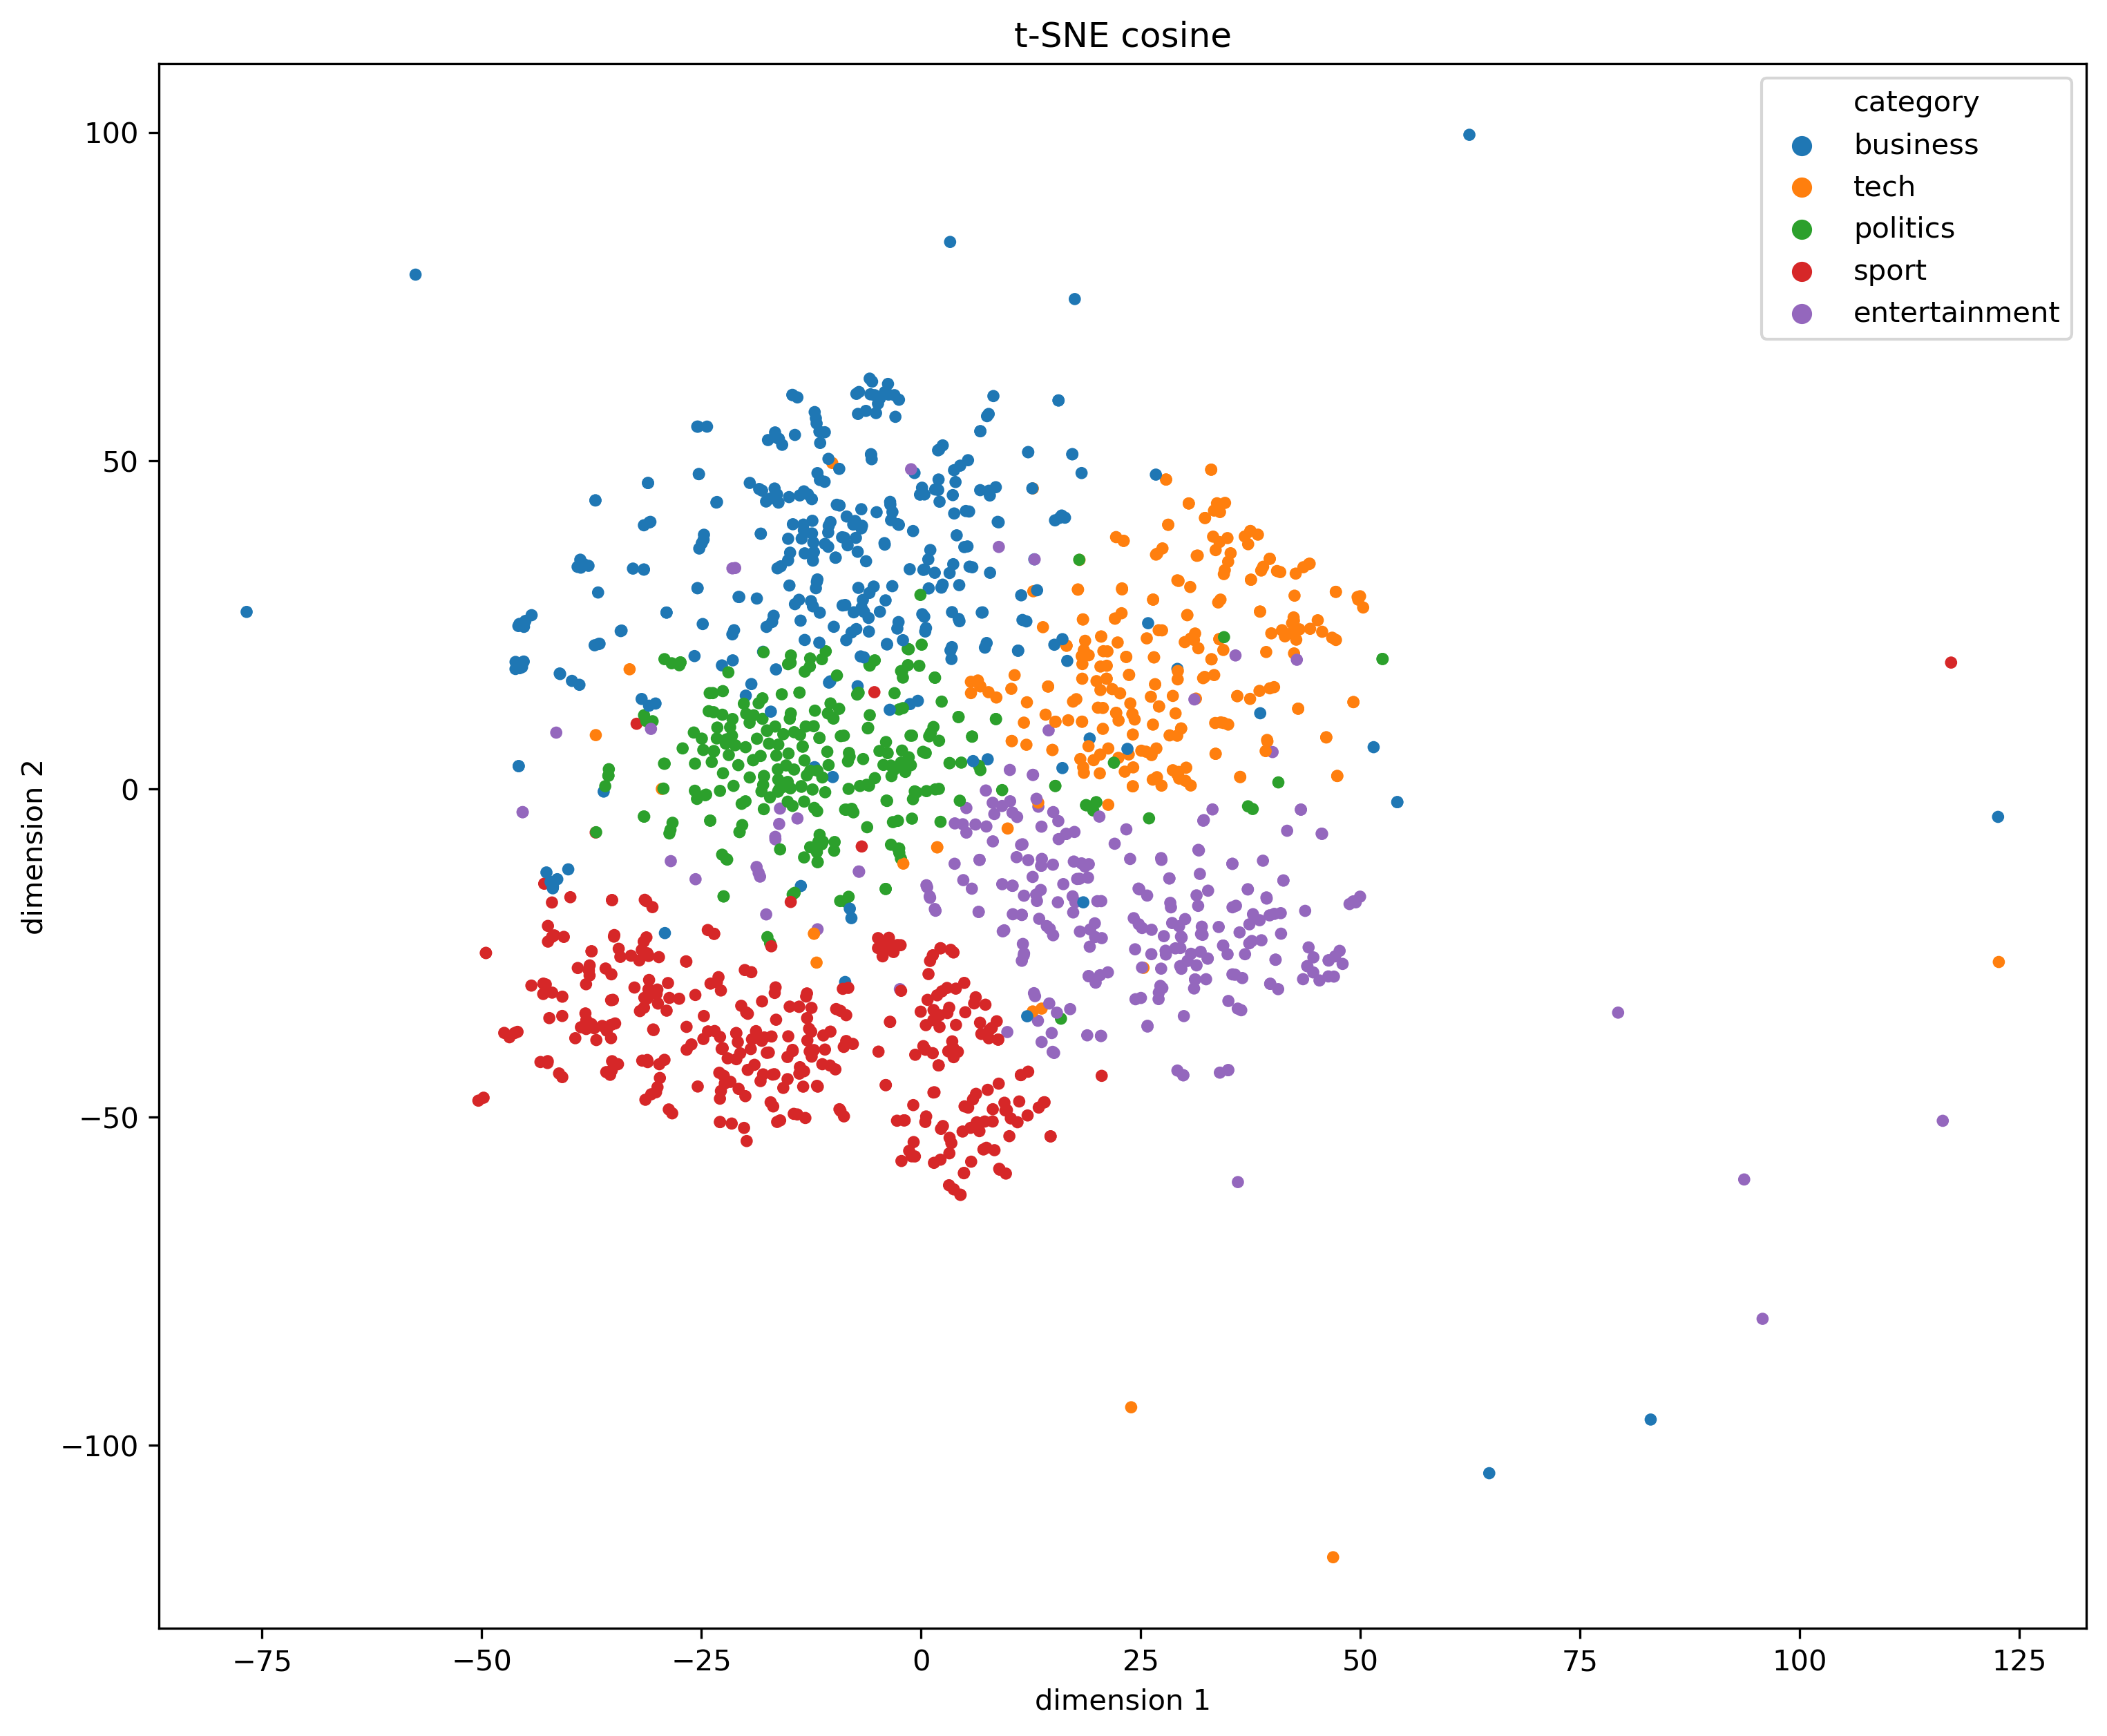

In [50]:
plot_outcome(TSNE(n_components=2,metric="cosine",random_state=123),topic='t-SNE cosine')

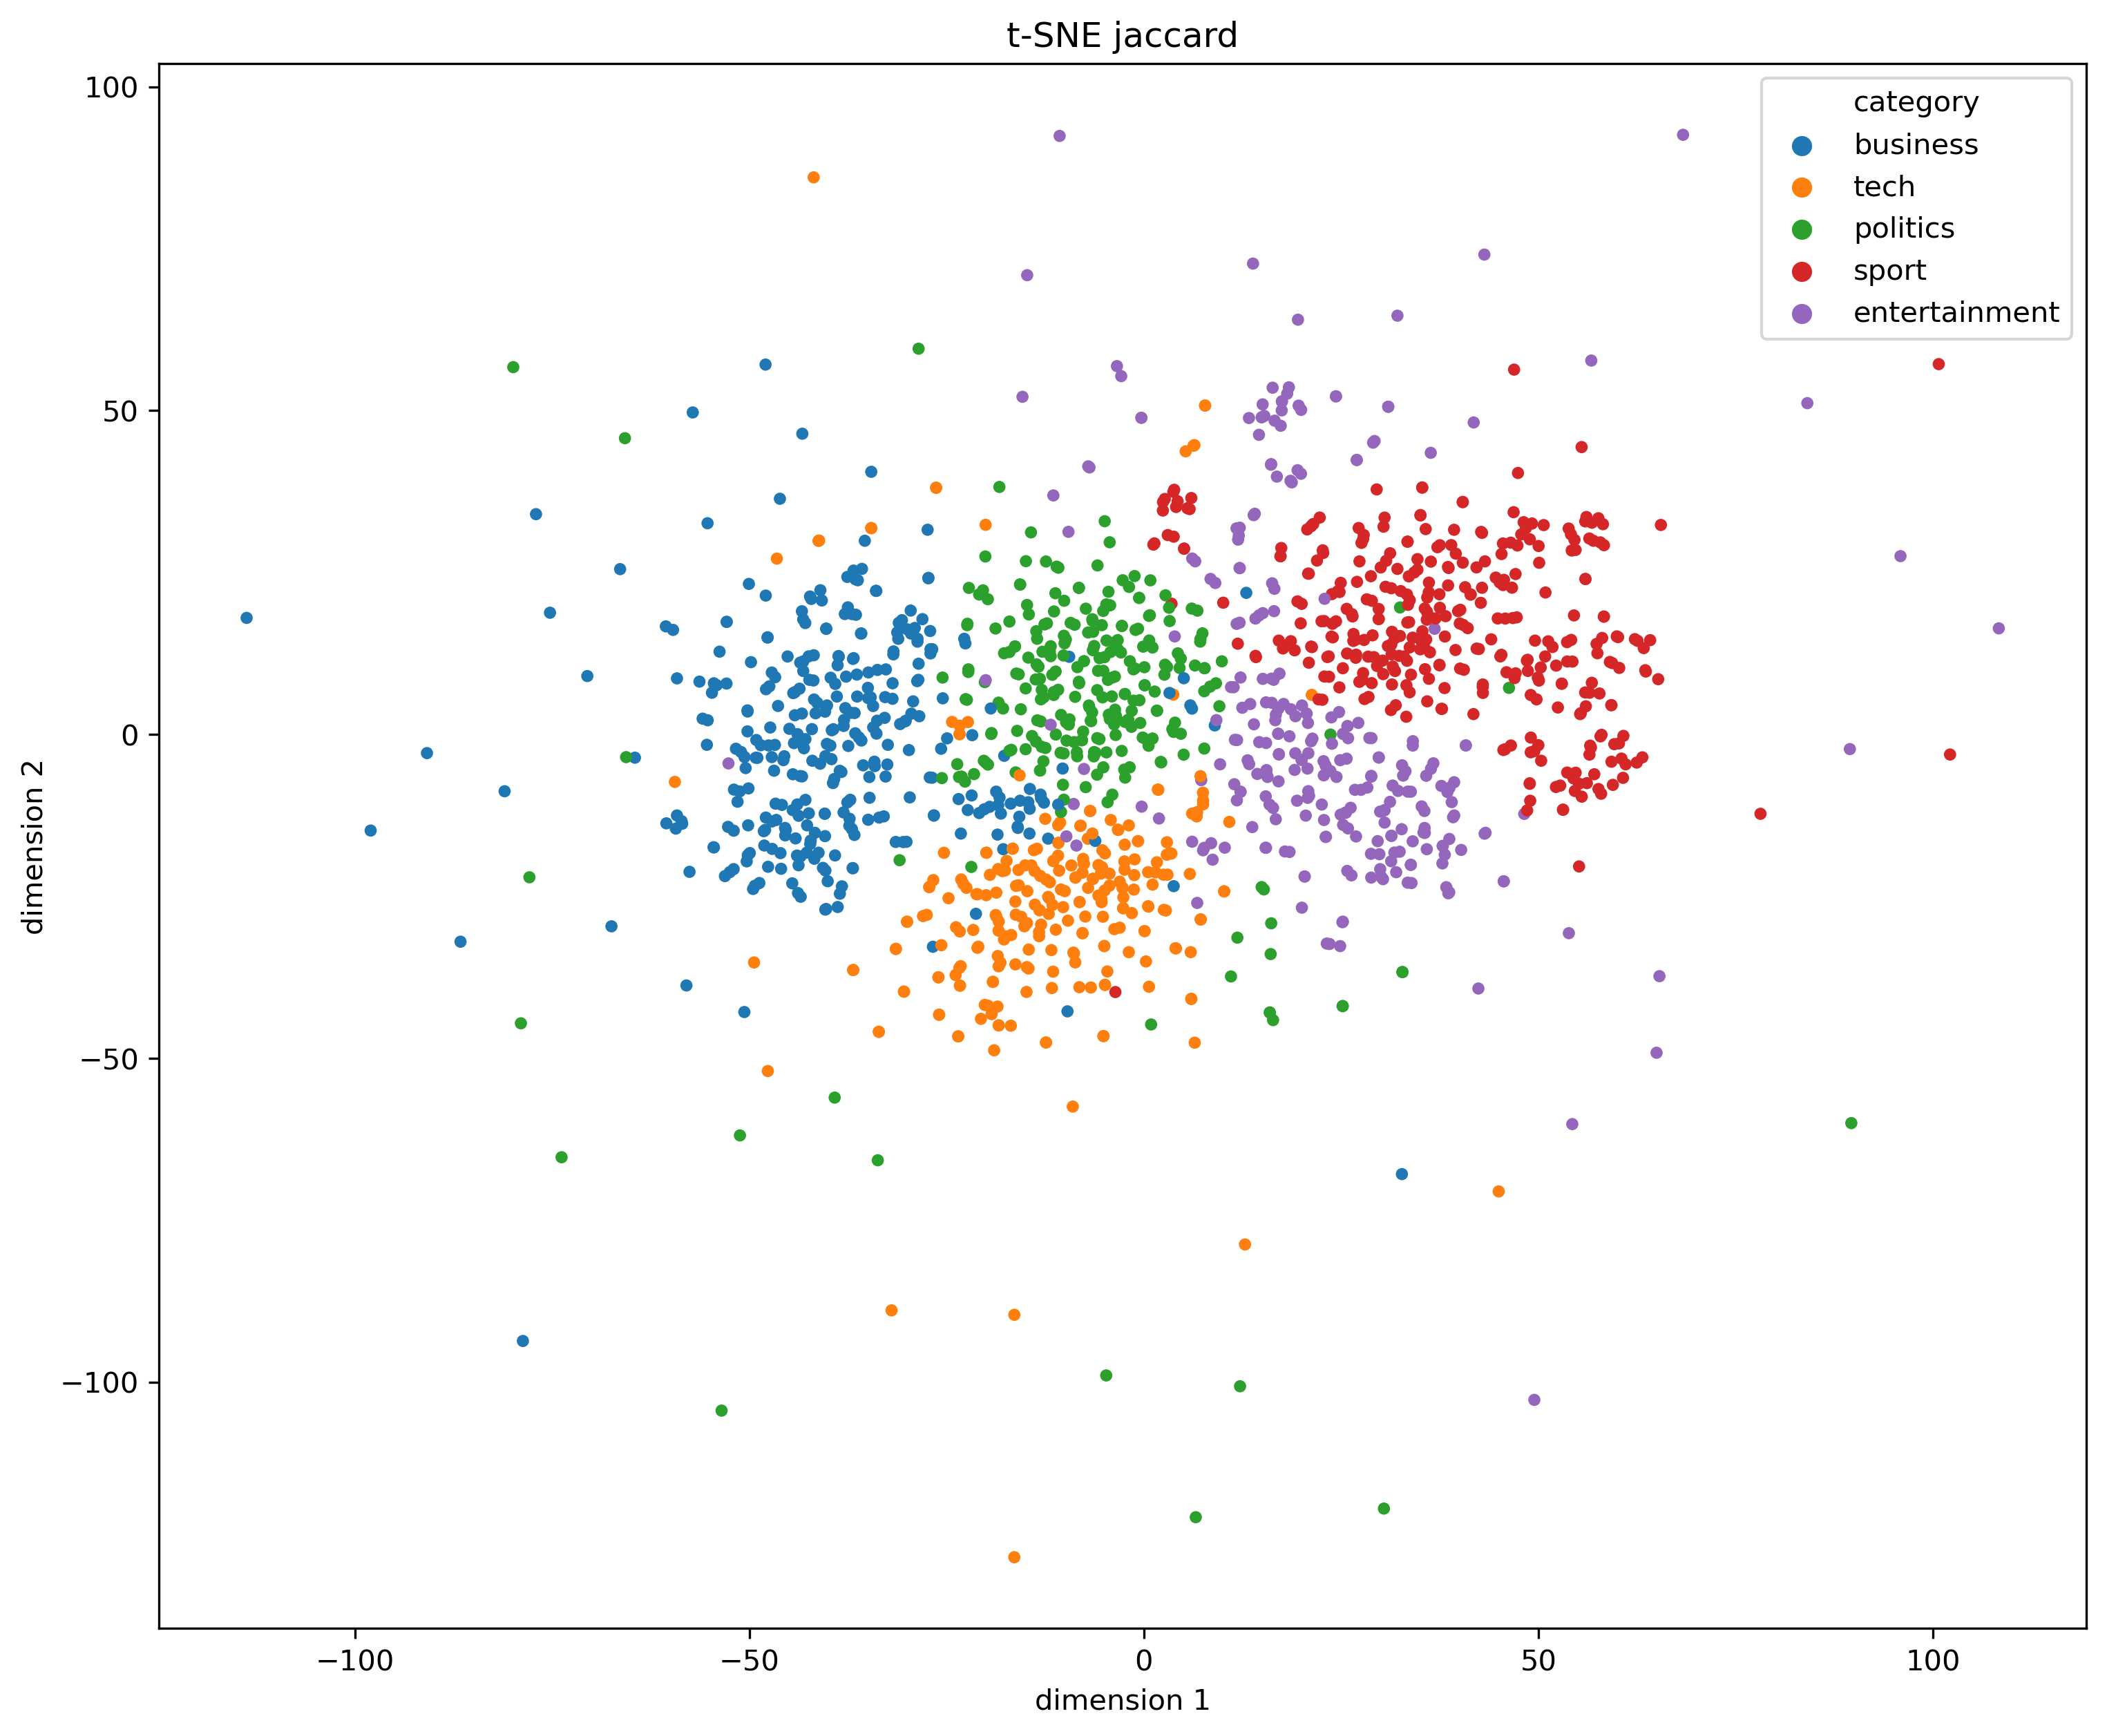

In [51]:
plot_outcome(TSNE(n_components=2,metric="jaccard",random_state=123),topic='t-SNE jaccard')